# Predicting bike rentals

For this project, we'll use data on bike rentals in Washington DC using a dataset compiled by Hadi Danaee-T at the University of Porto. The data can be downloaded from UC Irvine's [website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset contains the following columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't - previously signed up with the bike sharing program) 
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

We'll try to predict the 'cnt' column using all others except the casual and registered columns.

## Exploring the data

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


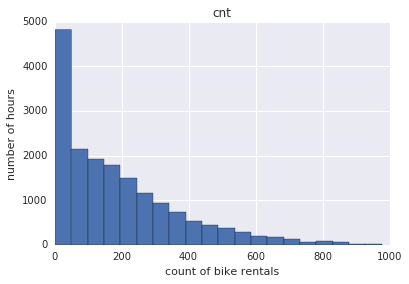

In [4]:
# plotting a histogram of rental counts
bike_rentals.hist(column='cnt',bins=20)
plt.xlabel('count of bike rentals')
plt.ylabel('number of hours')
plt.show()

From the histogram, we can see that the number of rentals per hour is right-skewed, with most hours (close to 5000) having 50 rentals or less, and a few with very high numbers of rentals of close to 1000.

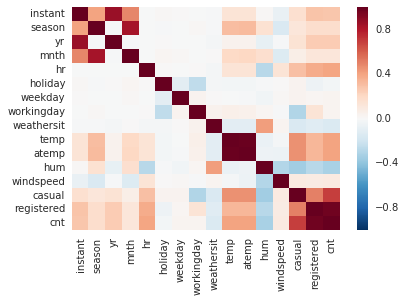

In [5]:
# plotting a heatmap of correlations between columns
correlations = bike_rentals.corr()
sns.heatmap(correlations)
plt.show()

From the heatmap, we can see that these columns have the strongest correlations with the 'cnt' column:

- Positive
    - hr
    - temp
    - atemp
- Negative
    - hum
    
Other columns are also highly correlated with 'cnt'.

We ignore the 'casual' and 'registered' columns as they're subsets of 'cnt'.

We can also see that 'season' and 'mth' are highly correlated, which is expected. The same goes for 'atemp' and 'temp'. So in both cases we should only use one of each pair of columns:

- season since it groups months by the expected weather
- atemp as this is what the temperature feels like and is likely to affect people's choices about cycling more

## Feature engineering

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

We'll start wiht the 'hr' column, which contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

In [6]:
# Creating a function to group hours into sections of the day
def assign_label(hr):
    if hr >=6 and hr <12:
        return 1
    elif hr >=12 and hr <18:
        return 2
    elif hr >=18 and hr <24:
        return 3
    elif hr >=0 and hr <6:
        return 4

In [7]:
# Applying the function to the dataframe
bike_rentals['time_label'] = bike_rentals['hr'].apply(lambda x: assign_label(x))


In [8]:
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


## Splitting the data and choosing an error metric

Before applying machine learning algorithms, let's split the data into training and testing sets.

We'll use root mean squared error (RMSE) to evaluate the predictions on this dataset as it is appropriate for continuous numerical variables.

In [14]:
# Splitting the data
train = bike_rentals.sample(frac=0.8,random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Testing different methods for predicting bike rental counts

### Linear regression

Linear regression works best when predictors are linearly correlated to the target and independent i.e. they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We'll start by removing the following columns:

- cnt (target column)
- casual & registered (subsets of cnt)
- dteday (not a continuous numerical variable)
- temp (since it is highly correlated with atemp)

In [27]:
features = ['season','yr','mnth','hr','holiday','weekday'
            ,'workingday','weathersit','atemp','hum','windspeed']

In [29]:
# instantiating and using a linear regression model
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
lr_pred = lr.predict(test[features])
lr_rmse = np.sqrt(mean_squared_error(test['cnt'],lr_pred))

print(lr_rmse)
# Using fewer features did not improve the error metric

139.94117854989577


In [19]:
mean_count = bike_rentals['cnt'].mean()
print(mean_count)

189.46308763450142


The rmse value is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Decision Trees

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [56]:
# instantiating and using a decision tree regression model
dt = DecisionTreeRegressor(min_samples_leaf=8)
dt.fit(train[features],train['cnt'])
dt_pred = dt.predict(test[features])
dt_rmse = np.sqrt(mean_squared_error(test['cnt'],dt_pred))

print(dt_rmse)
# Changing min_samples_leaf reduced the error metric
# Adjusting max_depth did not really decrease the error metric anymore

53.423538847084416


The decision tree regressor appears to produce a much lower rmse than the linear regression model as it takes nonlinear predictors into account as well. Given that it performs better, we can test a random forest regressor to see if that will improve performance further by reducing overfitting.

### Random Forest Regressor

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [70]:
# instantiating and using a random forest regression model
rf = RandomForestRegressor(max_depth=22)
rf.fit(train[features],train['cnt'])
rf_pred = rf.predict(test[features])
rf_rmse = np.sqrt(mean_squared_error(test['cnt'],rf_pred))

print(rf_rmse)
# min_samples_leaf with lowest rmse = 3 (46.8)
# max_depth = 22 produced lowest rmse (46.5)

47.47831137037577


The random forest regressor reduced the rmse a bit further by reducing overfitting. So it would be the best of the 3 methods here for predicting bike rental numbers

Potential next steps:

- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Predict casual and registered instead of cnt